In [1]:
from time import perf_counter
import numpy as np
from scipy.optimize import fsolve
from numba import njit

In [2]:
%matplotlib inline
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.family': 'serif', 'mathtext.fontset': 'dejavuserif',
                 'font.size': 12, 'text.latex.preamble': r"\usepackage{amsmath}",
                 'xtick.major.pad': 2, 'ytick.major.pad': 2, 'xtick.major.size': 6, 'ytick.major.size': 6,
                 'xtick.minor.size': 3, 'ytick.minor.size': 3, 'axes.linewidth': 2, 'axes.labelpad': 1})

def format_axis(ax: mpl.axes._axes.Axes) -> None:
    ax.minorticks_on(); ax.grid(visible=True, which='major', linestyle=':')
    ax.tick_params(axis='both', which='both', direction='out')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.patch.set_alpha(0.0)

# Exact Solution

In [3]:
def Keplers_equation(M, e):
    func = lambda x: x - e*np.sin(x) - M
    return fsolve(func, M)[0]

vKeplers_equation = np.vectorize(Keplers_equation)

In [4]:
a_test = 16.0  # semi-major axis
e_test = 63/64  # eccentricity
b_test = a_test * (1.0 - e_test ** 2.0) ** 0.5  # semi-minor axis
c_test = a_test * e_test  # focal distance axis
(a_test, e_test, b_test, c_test)

(16.0, 0.984375, 2.817356917396161, 15.75)

In [5]:
M_exact = np.linspace(0, 432/64, 432*64+1, dtype=float)  # mean anomaly
E_exact = vKeplers_equation(M_exact, e_test)  # eccentric anomaly

In [6]:
rxy_exact = np.empty((2, 432*64+1), dtype=float)  # exact position
rxy_exact[0] = (np.cos(E_exact) - e_test) * a_test
rxy_exact[1] = np.sin(E_exact) * b_test

In [7]:
EM_test = -1 / (a_test*2.0)  # mechanic energy
r0x_test = a_test - c_test  # initial position
r0_test = np.array([r0x_test, 0.0], dtype=np.float64)
v0y_test = (1/a_test * (1+e_test)/(1-e_test)) ** 0.5  # initial velocity
v0_test = np.array([0.0, v0y_test], dtype=np.float64)
Lz_test = (a_test * (1-e_test**2.0)) ** 0.5  # angular momentum
(EM_test, r0_test, v0_test, Lz_test)

(-0.03125,
 array([0.25, 0.  ]),
 array([0.        , 2.81735692]),
 0.7043392293490403)

In [8]:
@njit  # conservation correction
def CC_rxy_to_vxy(rxy, vxy, EM, Lz):
    vxy[0] = -rxy[1] * Lz
    vxy[1] = rxy[0] * Lz

    r2 = np.sum(np.square(rxy))
    sqrt_Deltar = max(2.0 * (r2**0.5 + EM*r2) - Lz**2.0, 0.0) ** 0.5
    vxy += np.sign(rxy[1]) * rxy * sqrt_Deltar

    vxy /= r2

In [9]:
vxy_exact = np.empty((2, 432*64+1), dtype=float)  # exact velocity
for i in range(432*64+1):
    CC_rxy_to_vxy(rxy_exact[:, i], vxy_exact[:, i], EM_test, Lz_test)

In [10]:
@njit  # mechanic energy
def EM_from_rxy_vxy(rxy, vxy):
    # r = np.sqrt(np.sum(np.square(rxy)))
    # v2 = np.sum(np.square(vxy))
    return -1.0/np.sqrt(np.sum(np.square(rxy))) + np.sum(np.square(vxy))/2.0

@njit  # angular momentum
def Lz_from_rxy_vxy(rxy, vxy):
    return rxy[0]*vxy[1] - rxy[1]*vxy[0]

In [11]:
exact_plot = False  # 4/28/2024, plot everything versus mean anomaly

if exact_plot:
    EM_recover = np.empty((432*64+1,), dtype=float)  # ``recovered'' mechanic energy
    Lz_recover = np.empty((432*64+1,), dtype=float)  # ``recovered'' angular momentum
    for i in range(432*64+1):
        EM_recover[i] = EM_from_rxy_vxy(rxy_exact[:, i], vxy_exact[:, i])
        Lz_recover[i] = Lz_from_rxy_vxy(rxy_exact[:, i], vxy_exact[:, i])

In [12]:
if exact_plot:
    fig, axs = plt.subplots(7, figsize=(12.8, 12.8), sharex='col')

    for ax, data, label in zip(axs, [E_exact, *rxy_exact, *vxy_exact, EM_recover - EM_test, Lz_recover - Lz_test],
                               ['Eccentric anomaly', 'Position ($x$ comp)', 'Position ($y$ comp)',
                                'Velocity ($x$ comp)', 'Velocity ($y$ comp)', '$\Delta$ Mechanic energy', '$\Delta$ Angular momentum']):
        ax.scatter(M_exact, data, c='tab:blue', s=0.1, rasterized=True)
        ax.set_ylabel(label)
        format_axis(ax)

    axs[-1].set_xlabel('Mean anomaly')
    axs[-1].set_xlim((-0.05, M_exact[-1]+0.05))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    plt.savefig('eccentric_exact.pdf', dpi=128)

# Common tools

In [13]:
@njit  # equation of motion
def EOM_rxy_to_axy(rxy, axy):
    axy[:] = -rxy
    r2 = rxy @ rxy
    axy /= r2 ** 1.5

In [14]:
def test_integrator(integrator):
    # uniform circular motion, as a test
    r0_UCM = np.array([1, 0], dtype=np.float64)
    v0_UCM = np.array([0, 1], dtype=np.float64)
    rvh_exact = np.empty((4,), dtype=np.float64)

    for h_test in [1/16, 1/64, 1/256, 1/1024]:
        rvh_exact[::3] = np.cos(h_test)
        rvh_exact[1] = np.sin(h_test)
        rvh_exact[2] = -rvh_exact[1]

        t_start = perf_counter()
        history = integrator(1, 1, h_test, r0_UCM, v0_UCM)
        t_end = perf_counter()
        print(f'h = {h_test:.4f}:', t_end-t_start, 's,', history[1] - rvh_exact)

In [15]:
# mechanic energy
def vEM_from_rxy_vxy(rxy, vxy):
    return -1.0/np.sqrt(np.einsum('si,si->s', rxy, rxy)) + np.einsum('si,si->s', vxy, vxy)/2.0

# angular momentum
def vLz_from_rxy_vxy(rxy, vxy):
    return rxy[:, 0]*vxy[:, 1] - rxy[:, 1]*vxy[:, 0]

In [16]:
COLOR = {16: 'tab:orange', 64: 'tab:green', 256: 'tab:red', 1024: 'tab:purple'}

def run_integrator(integrator):
    fig, axs = plt.subplots(1, 3, figsize=(12.8, 3.2))

    for h_res in [16, 64, 256, 1024]:
        Nstep = 432 * min(h_res, 64)
        Nsub = max(h_res // 64, 1)
        h = 1 / h_res

        t_start = perf_counter()
        history = integrator(Nstep, Nsub, h, r0_test, v0_test)
        t_end = perf_counter()
        print(f'h = {h:.4f}:', t_end-t_start, 's')

        ax = axs[0]
        ax.scatter(history[:, 0], history[:, 1], c=COLOR[h_res], s=0.1, rasterized=True)
        ax.plot([], [], c=COLOR[h_res], label=f'h = {h:.4f}')
        ax.set_xlabel('Position ($x$ comp)')
        ax.set_ylabel('Position ($y$ comp)')

        M_exact_ = M_exact if h_res != 16 else M_exact[::4]
        axs[1].scatter(M_exact_, vEM_from_rxy_vxy(history[:, :2], history[:, 2:]) - EM_test,
                       c=COLOR[h_res], s=0.1, rasterized=True)
        axs[1].set_ylabel('$\Delta$ Mechanic energy')
        axs[2].scatter(M_exact_, vLz_from_rxy_vxy(history[:, :2], history[:, 2:]) - Lz_test,
                       c=COLOR[h_res], s=0.1, rasterized=True)
        axs[2].set_ylabel('$\Delta$ Angular momentum')

    axs[0].legend()
    for i in range(1, 3):
        axs[i].set_yscale('asinh')
        axs[i].set_xlabel('Mean anomaly (exact)')
    for ax in axs: format_axis(ax)
    fig.tight_layout()
    plt.show()

# Leapfrog integrators

In [17]:
@njit
def LF_integrator(Nstep: int, Nsub: int, h: float,
                  r_init: np.array, v_init: np.array):
    history = np.empty((Nstep+1, 4), dtype=np.float64)
    history[0, :2] = r_init
    history[0, 2:] = v_init
    h_half = h / 2.0

    r_curr = r_init.copy()
    a_curr = np.empty((2,), dtype=np.float64)
    EOM_rxy_to_axy(r_curr, a_curr)
    v_curr = v_init - a_curr * h_half

    for j in range(1, Nstep+1):
        for i in range(Nsub):
            v_curr += a_curr * h
            r_curr += v_curr * h
            EOM_rxy_to_axy(r_curr, a_curr)
        history[j, :2] = r_curr
        history[j, 2:] = v_curr + a_curr * h_half

    return history

In [18]:
test_integrator(LF_integrator)

h = 0.0625: 0.7834304999996675 s, [-6.35700099e-07  4.06821576e-05  2.05314625e-05 -6.24524282e-07]
h = 0.0156: 1.790000533219427e-05 s, [-2.48350662e-09  6.35775117e-07  3.18073801e-07 -2.48077814e-09]
h = 0.0039: 4.4000043999403715e-06 s, [-9.70123981e-12  9.93409988e-09  4.96723184e-09 -9.70057368e-12]
h = 0.0010: 3.9000005926936865e-06 s, [-3.78586051e-14  1.55220422e-10  7.76103885e-11 -3.78586051e-14]


h = 0.0625: 0.0027545999982976355 s
h = 0.0156: 0.01217480000195792 s
h = 0.0039: 0.03650700000434881 s
h = 0.0010: 0.13113560000056168 s


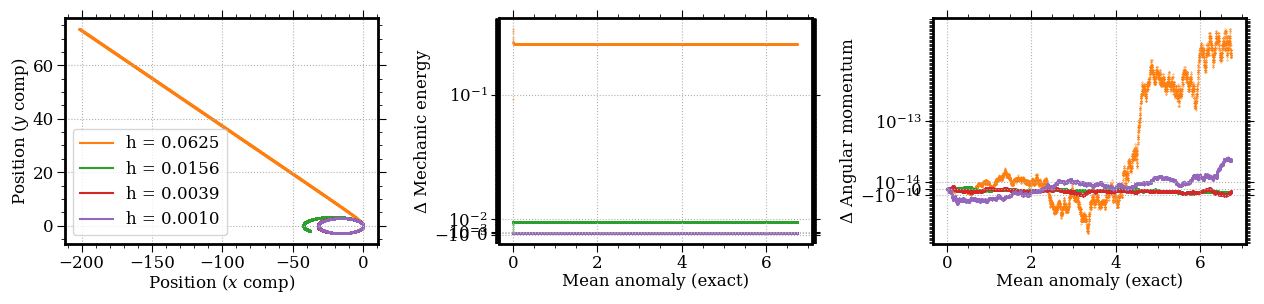

In [19]:
run_integrator(LF_integrator)

In [20]:
do_timeit = True  # 4/30/2024

if do_timeit:
    my_integrator = LF_integrator
    %timeit my_integrator(432*16, 1, 1/16, r0_test, v0_test)
    %timeit my_integrator(432*64, 1, 1/64, r0_test, v0_test)
    %timeit my_integrator(432*64, 4, 1/256, r0_test, v0_test)
    %timeit my_integrator(432*64, 16, 1/1024, r0_test, v0_test)

2.58 ms ± 62.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.3 ms ± 999 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.8 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
133 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
@njit
def LFCC_integrator(Nstep: int, Nsub: int, h: float,
                    r_init: np.array, v_init: np.array):
    history = np.empty((Nstep+1, 4), dtype=np.float64)
    history[0, :2] = r_init
    history[0, 2:] = v_init
    h_half = h / 2.0

    EM = EM_from_rxy_vxy(r_init, v_init)
    Lz = Lz_from_rxy_vxy(r_init, v_init)

    r_curr = r_init.copy()
    a_curr = np.empty((2,), dtype=np.float64)
    EOM_rxy_to_axy(r_curr, a_curr)
    v_curr = v_init.copy()

    for j in range(1, Nstep+1):
        for i in range(Nsub):
            v_curr += a_curr * h_half
            r_curr += v_curr * h
            EOM_rxy_to_axy(r_curr, a_curr)
            CC_rxy_to_vxy(r_curr, v_curr, EM, Lz)
        history[j, :2] = r_curr
        history[j, 2:] = v_curr

    return history

In [22]:
test_integrator(LFCC_integrator)

h = 0.0625: 1.0162055000037071 s, [-6.35700099e-07  4.06821576e-05 -4.04437400e-05 -4.44293226e-06]
h = 0.0156: 2.0499996026046574e-05 s, [-2.48350662e-09  6.35775117e-07 -6.35542286e-07 -1.73828486e-08]
h = 0.0039: 1.0700001439545304e-05 s, [-9.70123981e-12  9.93409988e-09 -9.93387251e-09 -6.79084566e-11]
h = 0.0010: 6.499998562503606e-06 s, [-3.78586051e-14  1.55220422e-10 -1.55220200e-10 -2.65232281e-13]


h = 0.0625: 0.004706900006567594 s
h = 0.0156: 0.014115400001173839 s
h = 0.0039: 0.05079949999344535 s
h = 0.0010: 0.20868179999524727 s


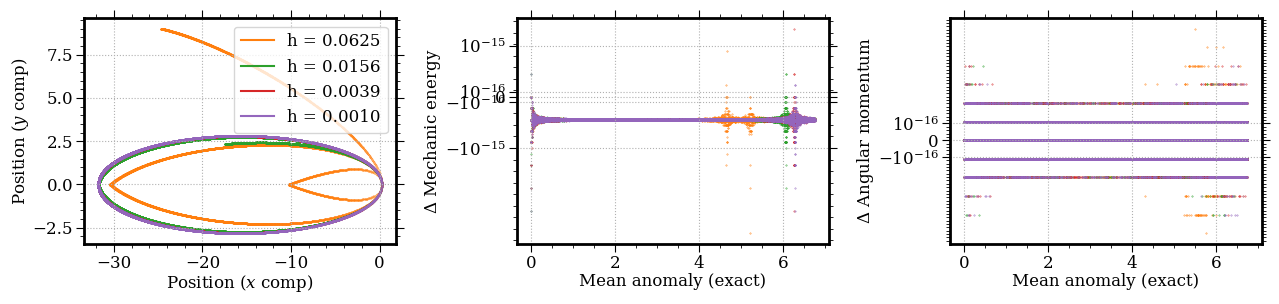

In [23]:
run_integrator(LFCC_integrator)

In [24]:
if do_timeit:
    my_integrator = LFCC_integrator
    %timeit my_integrator(432*16, 1, 1/16, r0_test, v0_test)
    %timeit my_integrator(432*64, 1, 1/64, r0_test, v0_test)
    %timeit my_integrator(432*64, 4, 1/256, r0_test, v0_test)
    %timeit my_integrator(432*64, 16, 1/1024, r0_test, v0_test)

3.16 ms ± 53.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
47.3 ms ± 688 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
210 ms ± 9.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Runge–Kutta integrators

In [25]:
@njit
def RK4_compute_k(rv, k):
    k[:2] = rv[2:]
    EOM_rxy_to_axy(rv[:2], k[2:])

In [26]:
@njit
def RK4_integrator(Nstep: int, Nsub: int, h: float,
                   r_init: np.array, v_init: np.array):
    history = np.empty((Nstep+1, 4), dtype=np.float64)
    history[0, :2] = r_init
    history[0, 2:] = v_init
    h_half = h / 2.0

    rv_curr = history[0].copy()
    k1234 = np.empty((4, 4), dtype=np.float64)
    weights = np.empty((4,), dtype=np.float64)
    weights[::3] = h_half / 3.0
    weights[1:3] = h / 3.0

    for j in range(1, Nstep+1):
        for i in range(Nsub):
            RK4_compute_k(rv_curr,                     k1234[0])  # compute k1
            RK4_compute_k(rv_curr + k1234[0] * h_half, k1234[1])  # compute k2
            RK4_compute_k(rv_curr + k1234[1] * h_half, k1234[2])  # compute k3
            RK4_compute_k(rv_curr + k1234[2] * h,      k1234[3])  # compute k4
            rv_curr += k1234.T @ weights
        history[j] = rv_curr

    return history

In [27]:
test_integrator(RK4_integrator)

h = 0.0625: 1.0149649999948451 s, [-3.80382725e-10 -7.99013156e-09 -6.94721854e-09 -3.84469456e-10]
h = 0.0156: 1.340000017080456e-05 s, [-9.33697564e-14 -7.76364042e-12 -6.79049351e-12 -9.34807787e-14]
h = 0.0039: 5.099995178170502e-06 s, [ 0.00000000e+00 -7.57900687e-15 -6.63141417e-15  0.00000000e+00]
h = 0.0010: 4.499997885432094e-06 s, [ 0.00000000e+00 -7.37257477e-18 -6.50521303e-18  0.00000000e+00]


h = 0.0625: 0.008220799994887784 s
h = 0.0156: 0.02967479999642819 s
h = 0.0039: 0.12083390000043437 s
h = 0.0010: 0.4861578999989433 s


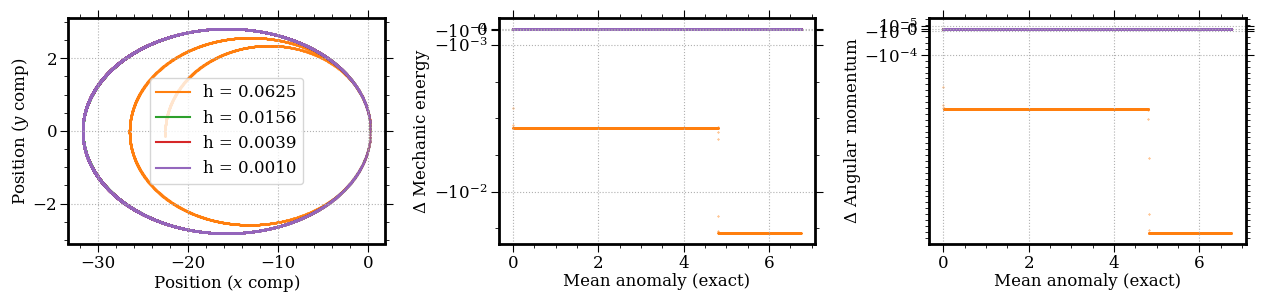

In [28]:
run_integrator(RK4_integrator)

In [29]:
if do_timeit:
    my_integrator = RK4_integrator
    %timeit my_integrator(432*16, 1, 1/16, r0_test, v0_test)
    %timeit my_integrator(432*64, 1, 1/64, r0_test, v0_test)
    %timeit my_integrator(432*64, 4, 1/256, r0_test, v0_test)
    %timeit my_integrator(432*64, 16, 1/1024, r0_test, v0_test)

7.99 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.7 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
131 ms ± 5.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
514 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
@njit
def RK4CC_integrator(Nstep: int, Nsub: int, h: float,
                     r_init: np.array, v_init: np.array):
    history = np.empty((Nstep+1, 4), dtype=np.float64)
    history[0, :2] = r_init
    history[0, 2:] = v_init
    h_half = h / 2.0

    EM = EM_from_rxy_vxy(r_init, v_init)
    Lz = Lz_from_rxy_vxy(r_init, v_init)

    rv_curr = history[0].copy()
    k1234 = np.empty((4, 4), dtype=np.float64)
    weights = np.empty((4,), dtype=np.float64)
    weights[::3] = h_half / 3.0
    weights[1:3] = h / 3.0

    for j in range(1, Nstep+1):
        for i in range(Nsub):
            RK4_compute_k(rv_curr,                     k1234[0])  # compute k1
            RK4_compute_k(rv_curr + k1234[0] * h_half, k1234[1])  # compute k2
            RK4_compute_k(rv_curr + k1234[1] * h_half, k1234[2])  # compute k3
            RK4_compute_k(rv_curr + k1234[2] * h,      k1234[3])  # compute k4
            rv_curr += k1234.T @ weights
            CC_rxy_to_vxy(rv_curr[:2], rv_curr[2:], EM, Lz)
        history[j] = rv_curr

    return history

In [31]:
test_integrator(RK4CC_integrator)

h = 0.0625: 0.5837779000066803 s, [-3.80382725e-10 -7.99013156e-09  7.88036579e-09  1.37358247e-09]
h = 0.0156: 2.2100000933278352e-05 s, [-9.33697564e-14 -7.76364042e-12  7.75693051e-12  3.36064510e-13]
h = 0.0039: 6.299997039604932e-06 s, [ 0.00000000e+00 -7.57900687e-15  7.57857319e-15  1.11022302e-16]
h = 0.0010: 8.499999239575118e-06 s, [ 0.00000000e+00 -7.37257477e-18  7.26415456e-18  1.11022302e-16]


h = 0.0625: 0.008704499996383674 s
h = 0.0156: 0.03571400000510039 s
h = 0.0039: 0.15363159999833442 s
h = 0.0010: 0.5915081999992253 s


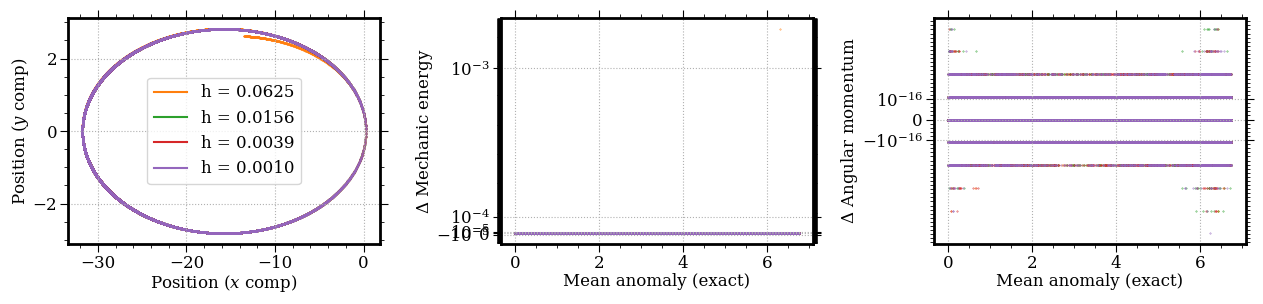

In [32]:
run_integrator(RK4CC_integrator)

In [33]:
if do_timeit:
    my_integrator = RK4CC_integrator
    %timeit my_integrator(432*16, 1, 1/16, r0_test, v0_test)
    %timeit my_integrator(432*64, 1, 1/64, r0_test, v0_test)
    %timeit my_integrator(432*64, 4, 1/256, r0_test, v0_test)
    %timeit my_integrator(432*64, 16, 1/1024, r0_test, v0_test)

8.97 ms ± 467 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
39.2 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
146 ms ± 9.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
631 ms ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# ContEvol integrators

In [34]:
@njit
def CE1_integrator(Nstep: int, Nsub: int, h: float,
                   r_init: np.array, v_init: np.array):
    history = np.empty((Nstep+1, 4), dtype=np.float64)
    history[0, :2] = r_init
    history[0, 2:] = v_init
    # h^2/2, h^3/6, h^4/24, h^5/120
    h_powers = np.empty((4,), dtype=np.float64)
    h_powers[0] = h ** 2.0 / 2.0
    for k in range(1, 4):
        h_powers[k] = h_powers[k-1] * h / (k+2.0)

    r_curr = r_init.copy()
    v_curr = v_init.copy()

    # r^2, r^-3, r^-5, r^-7, and r^-9
    r_powers = np.empty((5,), dtype=np.float64)
    # r@v, (r@v)^2, and v@v + r@a
    dot_products = np.empty((3,), dtype=np.float64)
                # acceleration, jerk, snap, and crackle
    derivatives = np.empty((4, 2), dtype=np.float64)

    for j in range(1, Nstep+1):
        for i in range(Nsub):
            r_powers[0] = r_curr @ r_curr
            r_powers[1] = r_powers[0] ** -1.5
            for k in range(2, 5):
                r_powers[k] = r_powers[k-1] / r_powers[0]

            dot_products[0] = r_curr @ v_curr
            dot_products[1] = dot_products[0] ** 2.0
            # compute acceleration
            derivatives[0] = -r_powers[1] * r_curr
            dot_products[2] = v_curr @ v_curr + r_curr @ derivatives[0]

            # compute jerk
            derivatives[1] = -r_powers[1] * v_curr
            derivatives[1] += 3*r_powers[2]*dot_products[0] * r_curr
            # compute snap
            derivatives[2] = -r_powers[1] * derivatives[0]
            derivatives[2] += 3*r_powers[2] * (2*dot_products[0] * v_curr + dot_products[2] * r_curr)
            derivatives[2] -= 15*r_powers[3]*dot_products[1] * r_curr
            # compute crackle
            derivatives[3] = -r_powers[1] * derivatives[1]
            derivatives[3] += 3*r_powers[2] * (3*(dot_products[0] * derivatives[0] + dot_products[2] * v_curr)
                                               + (3*v_curr@derivatives[0] + r_curr@derivatives[1]) * r_curr)
            derivatives[3] -= 45*r_powers[3] * (dot_products[1] * v_curr + dot_products[0]*dot_products[2] * r_curr)
            derivatives[3] += 105*r_powers[4]*dot_products[0]*dot_products[1] * r_curr

            # update position
            r_curr += v_curr * h
            r_curr += derivatives.T @ h_powers

            # update velocity
            v_curr += derivatives[0] * h
            v_curr += derivatives[1:].T @ h_powers[:3]

        history[j, :2] = r_curr
        history[j, 2:] = v_curr

    return history

In [35]:
test_integrator(CE1_integrator)

h = 0.0625: 1.4383996999968076 s, [8.27784508e-11 7.39103223e-13 7.94654686e-09 8.27784508e-11]
h = 0.0156: 1.4299999747890979e-05 s, [2.02060590e-14 4.51028104e-17 7.76097589e-12 2.02060590e-14]
h = 0.0039: 5.899993993807584e-06 s, [0.00000000e+00 0.00000000e+00 7.57900687e-15 0.00000000e+00]
h = 0.0010: 5.299996701069176e-06 s, [0.00000000e+00 0.00000000e+00 7.37257477e-18 0.00000000e+00]


h = 0.0625: 0.013067899999441579 s
h = 0.0156: 0.04945849999785423 s
h = 0.0039: 0.19093789999897126 s
h = 0.0010: 0.7739261999959126 s


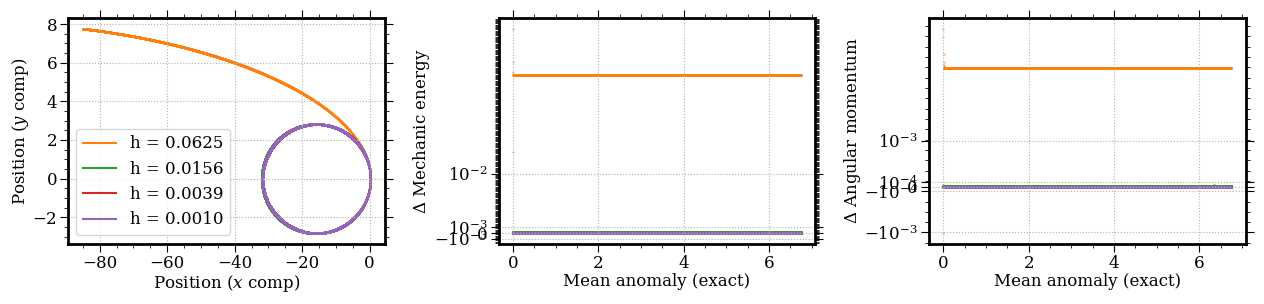

In [36]:
run_integrator(CE1_integrator)

In [37]:
if do_timeit:
    my_integrator = CE1_integrator
    %timeit my_integrator(432*16, 1, 1/16, r0_test, v0_test)
    %timeit my_integrator(432*64, 1, 1/64, r0_test, v0_test)
    %timeit my_integrator(432*64, 4, 1/256, r0_test, v0_test)
    %timeit my_integrator(432*64, 16, 1/1024, r0_test, v0_test)

11.6 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
45.5 ms ± 365 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
193 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
734 ms ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
@njit
def CE1CC_integrator(Nstep: int, Nsub: int, h: float,
                     r_init: np.array, v_init: np.array):
    history = np.empty((Nstep+1, 4), dtype=np.float64)
    history[0, :2] = r_init
    history[0, 2:] = v_init
    # h^2/2, h^3/6, h^4/24, h^5/120
    h_powers = np.empty((4,), dtype=np.float64)
    h_powers[0] = h ** 2.0 / 2.0
    for k in range(1, 4):
        h_powers[k] = h_powers[k-1] * h / (k+2.0)

    EM = EM_from_rxy_vxy(r_init, v_init)
    Lz = Lz_from_rxy_vxy(r_init, v_init)

    r_curr = r_init.copy()
    v_curr = v_init.copy()

    # r^2, r^-3, r^-5, r^-7, and r^-9
    r_powers = np.empty((5,), dtype=np.float64)
    # r@v, (r@v)^2, and v@v + r@a
    dot_products = np.empty((3,), dtype=np.float64)
                # acceleration, jerk, snap, and crackle
    derivatives = np.empty((4, 2), dtype=np.float64)

    for j in range(1, Nstep+1):
        for i in range(Nsub):
            r_powers[0] = r_curr @ r_curr
            r_powers[1] = r_powers[0] ** -1.5
            for k in range(2, 5):
                r_powers[k] = r_powers[k-1] / r_powers[0]

            dot_products[0] = r_curr @ v_curr
            dot_products[1] = dot_products[0] ** 2.0
            # compute acceleration
            derivatives[0] = -r_powers[1] * r_curr
            dot_products[2] = v_curr @ v_curr + r_curr @ derivatives[0]

            # compute jerk
            derivatives[1] = -r_powers[1] * v_curr
            derivatives[1] += 3*r_powers[2]*dot_products[0] * r_curr
            # compute snap
            derivatives[2] = -r_powers[1] * derivatives[0]
            derivatives[2] += 3*r_powers[2] * (2*dot_products[0] * v_curr + dot_products[2] * r_curr)
            derivatives[2] -= 15*r_powers[3]*dot_products[1] * r_curr
            # compute crackle
            derivatives[3] = -r_powers[1] * derivatives[1]
            derivatives[3] += 3*r_powers[2] * (3*(dot_products[0] * derivatives[0] + dot_products[2] * v_curr)
                                               + (3*v_curr@derivatives[0] + r_curr@derivatives[1]) * r_curr)
            derivatives[3] -= 45*r_powers[3] * (dot_products[1] * v_curr + dot_products[0]*dot_products[2] * r_curr)
            derivatives[3] += 105*r_powers[4]*dot_products[0]*dot_products[1] * r_curr

            # update position
            r_curr += v_curr * h
            r_curr += derivatives.T @ h_powers

            # update velocity
            CC_rxy_to_vxy(r_curr, v_curr, EM, Lz)

        history[j, :2] = r_curr
        history[j, 2:] = v_curr

    return history

In [39]:
test_integrator(CE1CC_integrator)

h = 0.0625: 1.449644199994509 s, [ 8.27784508e-11  7.39103223e-13  9.58704643e-12 -8.22247825e-11]
h = 0.0156: 2.5399996957276016e-05 s, [ 2.02060590e-14  4.51028104e-17  5.86336535e-16 -2.02060590e-14]
h = 0.0039: 1.7600003047846258e-05 s, [0. 0. 0. 0.]
h = 0.0010: 9.10000380827114e-06 s, [ 0.00000000e+00  0.00000000e+00 -1.08420217e-19  1.11022302e-16]


h = 0.0625: 0.017621600003622007 s
h = 0.0156: 0.0592294000016409 s
h = 0.0039: 0.18351590000384022 s
h = 0.0010: 0.7601144000000204 s


Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks ([-9.200000000000001e-05, ..., 0.0019240000000000004]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1009 ticks

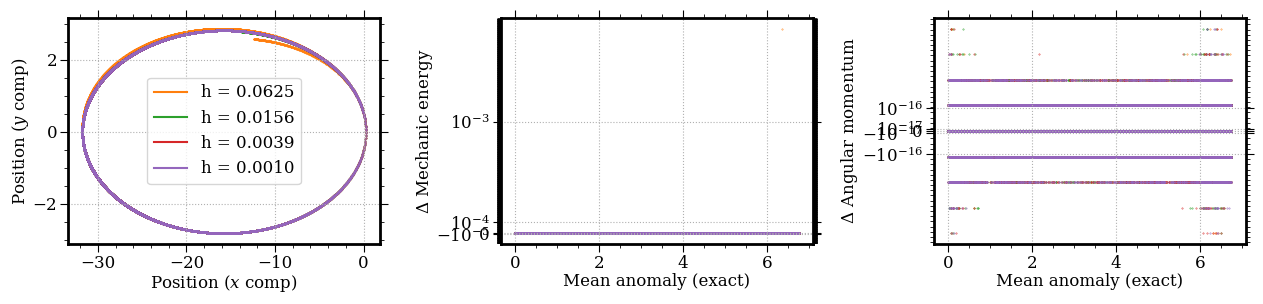

In [40]:
run_integrator(CE1CC_integrator)

In [41]:
if do_timeit:
    my_integrator = CE1CC_integrator
    %timeit my_integrator(432*16, 1, 1/16, r0_test, v0_test)
    %timeit my_integrator(432*64, 1, 1/64, r0_test, v0_test)
    %timeit my_integrator(432*64, 4, 1/256, r0_test, v0_test)
    %timeit my_integrator(432*64, 16, 1/1024, r0_test, v0_test)

11.3 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
45 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
181 ms ± 9.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
718 ms ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
